In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_modeling import *
import seaborn as sns

Locations of BCs and their synapses

In [2]:
BC_locations = np.load('Synapses/BC_locations_OFF.npy', allow_pickle = True)
synapse_locations = np.load('Synapses/synapse_locations_OFF.npy', allow_pickle = True)
BC_types = np.load('Synapses/BC_types_OFF.npy', allow_pickle = True)

Resolution of data

In [3]:
spatial_conversion = np.load('BC Data/spatial_conversion_um2pixel.npy')[0] # From um to pixel
temporal_conversion = np.load('BC Data/temporal_conversion_sec2pixel.npy')[0] # From seconds to pixel

Load kernels and flip time axis

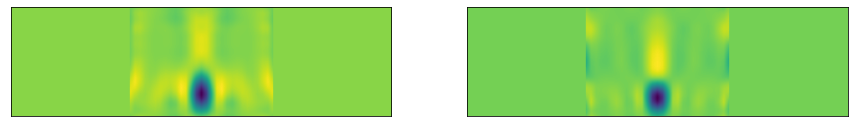

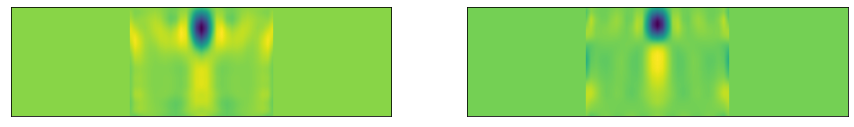

In [4]:
kernel_c12_t2 = np.load('BC Data/cluster_12_type_2.npy')
kernel_c1_t3b = np.load('BC Data/cluster_1_type_3b.npy')

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(kernel_c12_t2)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(kernel_c1_t3b)
plt.xticks([])
plt.yticks([])
plt.show()

# Flip temporal axis
kernel_c12_t2 = np.flipud(kernel_c12_t2)
kernel_c1_t3b = np.flipud(kernel_c1_t3b)

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(kernel_c12_t2)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(kernel_c1_t3b)
plt.xticks([])
plt.yticks([])
plt.show()

## Fig. 6d

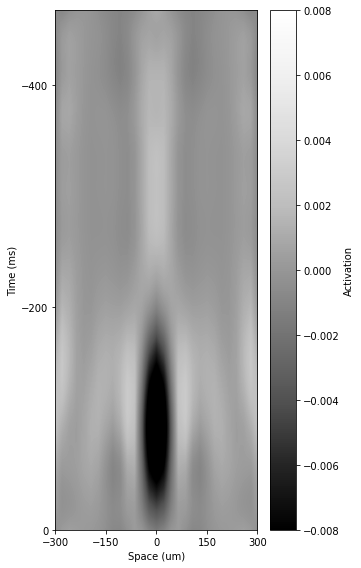

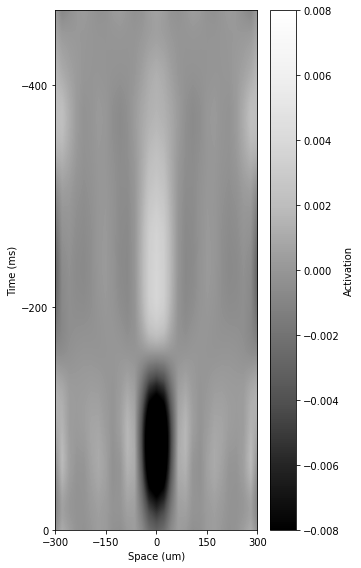

In [5]:
plt.figure(figsize=(5,8))
plt.imshow(np.flipud(kernel_c12_t2), aspect = 'auto', cmap = 'Greys_r',
           vmin = -0.008, vmax = 0.008, extent = [-800, 800, 0, -467.2])
plt.colorbar(label = 'Activation')
plt.xlim([-300,300])
plt.xticks([-300,-150,0,150,300])
plt.yticks([-400,-200,0])
plt.ylabel('Time (ms)')
plt.xlabel('Space (um)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,8))
plt.imshow(np.flipud(kernel_c1_t3b), aspect = 'auto', cmap = 'Greys_r',
           vmin = -0.008, vmax = 0.008, extent = [-800, 800, 0, -467.2])
plt.colorbar(label = 'Activation')
plt.xlim([-300,300])
plt.xticks([-300,-150,0,150,300])
plt.yticks([-400,-200,0])
plt.ylabel('Time (ms)')
plt.xlabel('Space (um)')
plt.tight_layout()
plt.show()

Get BC kernels specific to their location along the SAC

In [6]:
BC_types

array(['1', '1', '1', '3a', '3a'], dtype='<U21')

In [7]:
right_extension = 0
left_extension = 0

# 3 type 1 cells
BC1_1 = get_BC_kernel(kernel_c12_t2, BC_locations[0], right_extension, left_extension, spatial_conversion)
BC1_2 = get_BC_kernel(kernel_c12_t2, BC_locations[1], right_extension, left_extension, spatial_conversion)
BC1_3 = get_BC_kernel(kernel_c12_t2, BC_locations[2], right_extension, left_extension, spatial_conversion)

# 2 type 3a cells
BC3a_1 = get_BC_kernel(kernel_c1_t3b, BC_locations[3], right_extension, left_extension, spatial_conversion)
BC3a_2 = get_BC_kernel(kernel_c1_t3b, BC_locations[4], right_extension, left_extension, spatial_conversion)

kernels = [BC1_1, BC1_2, BC1_3, BC3a_1, BC3a_2]

Plot all BC kernels at their specific locations weighted by their number of synapses on top of each other

In [8]:
total_kernel = np.zeros_like(BC1_1)

for index, kernel in enumerate(kernels): 
    total_kernel = total_kernel + len(synapse_locations[index])*kernel

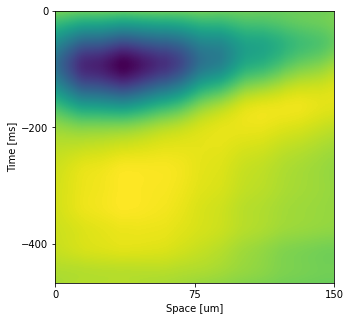

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(total_kernel, aspect = 'auto', extent = [0, 150, -467, 0])
plt.xlabel('Space [um]')
plt.ylabel('Time [ms]')
plt.xticks([0,75,150])
plt.yticks([0,-200,-400])
plt.show()

Define dataframe containing modeling results

In [10]:
columns = ['Model type',
           'BC distribution',
           'Cluster types',
           'Dendrite length [um]',
           'Stimulus velocity [um/s]', 
           'Bar size [um]',
           'Method',
           'dt Brian2',
           'Baseline input',
           'Response scaling',
           'Clipping',
           'BC input outward', 
           'BC input inward',
           'Motion duration [ms]',
           'State monitor', 
           'Membrane potential outward [mV]', 
           'Membrane potential inward [mV]', 
           'DSI voltage compartments', 
           'Mean DSI voltage distal dendrite', 
           'Calcium concentration outward [nM]', 
           'Calcium concentration inward [nM]', 
           'DSI calcium compartments', 
           'Mean DSI calcium distal dendrite',
           'Calcium current outward',
           'Calcium current inward']

SAC_model = pd.DataFrame(columns = columns)

Run model

In [11]:
stimulus_velocities = np.load('stimulus_velocities_um_s.npy') #um/s
length_dendrite = 150 + right_extension + left_extension
bar_size = 20 #um
model_type = 'OFF'
method = 'exponential_euler'
dt_brian = 0.1
set_params = True
my_baseline = 0.027
my_scaling = 0.000019
clipping = True

for current_velocity in stimulus_velocities: 
    print('Velocity: ' + str(current_velocity))
    
    outward_stimulus = np.load(
        'Stimuli/lenghtDendrite_' + str(length_dendrite) + 'um_lengthMB_' + str(
            bar_size) + 'um/velocity_' + str(current_velocity) + 'um_s.npy')
    inward_stimulus = np.fliplr(outward_stimulus)
    
    outward_stimulus = outward_stimulus.astype('float64')
    inward_stimulus = inward_stimulus.astype('float64')
    
    if model_type == 'OFF':
        outward_stimulus = (-1)*outward_stimulus
        inward_stimulus = (-1)*inward_stimulus
    
   
    state_monitor, BC_outward_input, BC_inward_input, motion_duration_ms  = run_model(
        kernels, synapse_locations, right_extension, left_extension, outward_stimulus, inward_stimulus, 
        spatial_conversion, temporal_conversion, baseline_activity=my_baseline,response_scaling=my_scaling,
        clipping=clipping, set_parameters=set_params,method_brian=method, dt_brian=dt_brian)
    
    
    (v_out, v_in, DSI_v, mean_DSI_v, ca_out, ca_in,
     DSI_ca, mean_DSI_ca, ICa_outward, ICa_inward) = response_extraction(state_monitor,
                                                                         motion_duration_ms,
                                                                         spatial_conversion)

    current_data = [model_type, 
                    'Original',
                    'c12_t2 & c1_t3b',
                    length_dendrite,
                    current_velocity, 
                    bar_size,
                    method,
                    dt_brian,
                    my_baseline,
                    my_scaling,
                    clipping,
                    BC_outward_input,
                    BC_inward_input,
                    motion_duration_ms,
                    state_monitor,
                    v_out,
                    v_in,
                    DSI_v,
                    mean_DSI_v,
                    ca_out,
                    ca_in,
                    DSI_ca,
                    mean_DSI_ca,
                    ICa_outward, 
                    ICa_inward]
    
    SAC_model = pd.concat([SAC_model, pd.DataFrame([current_data], columns = columns)], ignore_index = True)


Velocity: 250


WARNING    Variable Ri is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]
WARNING    Group uses a dt of 100. us while TimedArray uses dt of 1.00042827 ms [brian2.input.timedarray]


Velocity: 350
Velocity: 500
Velocity: 750
Velocity: 800
Velocity: 1000
Velocity: 1250
Velocity: 1500
Velocity: 1750
Velocity: 2000


Plot membrane voltage in the last compartment for each velocity

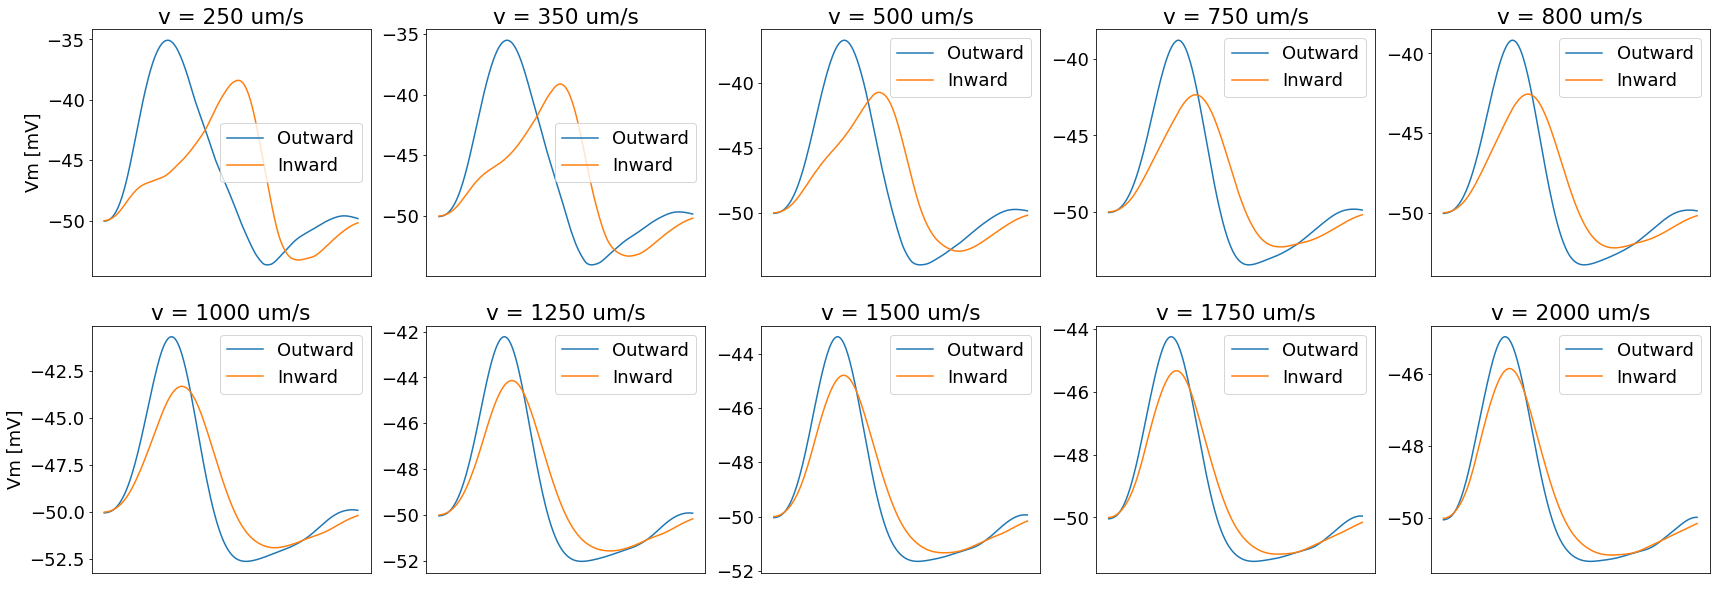

In [12]:
plt.figure(figsize=(29,10))
size = 18
plt.rcParams.update({'font.size': size})
for index, row in SAC_model.iterrows():
    
    plt.subplot(2,5,index+1)
    plt.title('v = ' + str(row['Stimulus velocity [um/s]']) + ' um/s')
    plt.plot(row['Membrane potential outward [mV]'][-1,:], label = 'Outward')
    plt.plot(row['Membrane potential inward [mV]'][-1,:], label = 'Inward')
    plt.xticks([])
    if index == 0 or index == 5:
        plt.ylabel('Vm [mV]')
    plt.legend(prop={'size': 18})

plt.show()

Save mean DSI calculated on membrane potential

In [13]:
#np.save('DSI values/OFF_Model_t2_t3b_mean_DSI_v.npy', SAC_model['Mean DSI voltage distal dendrite'].values)

## Fig. 6f

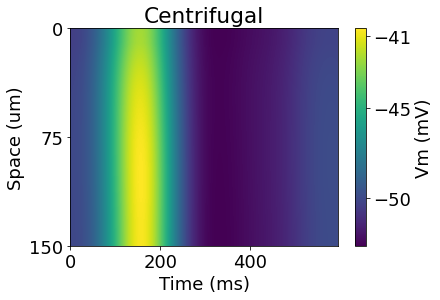

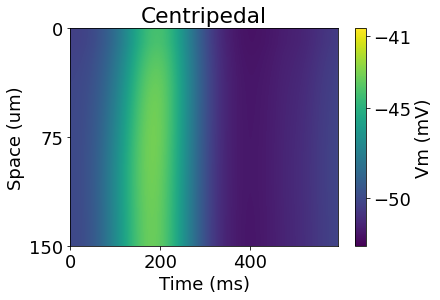

In [14]:
velocity = 1000

voltage_outward = SAC_model[
    'Membrane potential outward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0]
voltage_inward = SAC_model[
    'Membrane potential inward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0]
time_out = voltage_outward.shape[1]
time_in = voltage_inward.shape[1]

max_ = np.amax((np.amax(voltage_outward), np.amax(voltage_inward)))
min_ = np.amin((np.amin(voltage_outward), np.amin(voltage_inward)))


plt.imshow(voltage_outward, aspect = 'auto', vmin = min_, vmax = max_, cmap = 'viridis',
           extent = [0,time_out*dt_brian, 150, 0])
plt.title('Centrifugal')
plt.colorbar(ticks = [-50, -45, -41], label = 'Vm (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Space (um)')
plt.yticks([0,75,150])
plt.show()


plt.imshow(voltage_inward, aspect = 'auto', vmin = min_, vmax = max_, cmap = 'viridis',
           extent = [0,time_in*dt_brian, 150, 0])
plt.title('Centripedal')
plt.colorbar(ticks = [-50, -45, -41], label = 'Vm (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Space (um)')
plt.yticks([0,75,150])
plt.show()

## Fig. 6g

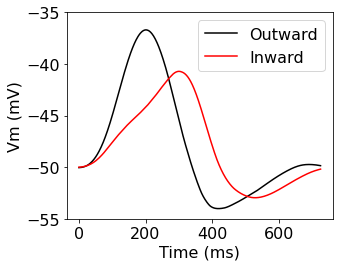

In [15]:
velocity = 500

plt.figure(figsize=(5,4))
size = 16
plt.rcParams.update({'font.size': size})
plt.rcParams.update({'axes.titlesize': size})
plt.rcParams.update({'axes.labelsize': size})
plt.rcParams.update({'xtick.labelsize': size})
plt.rcParams.update({'ytick.labelsize': size})

voltage_out = SAC_model[
    'Membrane potential outward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0][:]
voltage_in = SAC_model[
    'Membrane potential inward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0][:]
time_out = voltage_out.shape[1]
time_in = voltage_in.shape[1]

plt.plot(np.linspace(0,time_out*dt_brian,time_out), voltage_out[-1,:], color = 'black', label = 'Outward')
plt.plot(np.linspace(0,time_in*dt_brian,time_in), voltage_in[-1,:], color = 'red', label = 'Inward')
plt.ylabel('Vm (mV)')
plt.xlabel('Time (ms)')
plt.legend()
plt.yticks([-55,-50,-45,-40,-35])
plt.tight_layout()
plt.show()

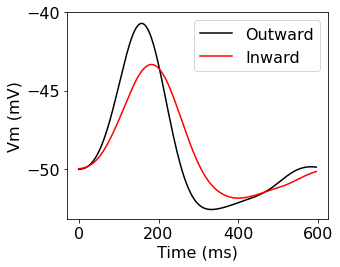

In [16]:
velocity = 1000

plt.figure(figsize=(5,4))
size = 16
plt.rcParams.update({'font.size': size})
plt.rcParams.update({'axes.titlesize': size})
plt.rcParams.update({'axes.labelsize': size})
plt.rcParams.update({'xtick.labelsize': size})
plt.rcParams.update({'ytick.labelsize': size})

voltage_out = SAC_model[
    'Membrane potential outward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0][:]
voltage_in = SAC_model[
    'Membrane potential inward [mV]'].loc[SAC_model['Stimulus velocity [um/s]'] == velocity].values[0][:]
time_out = voltage_out.shape[1]
time_in = voltage_in.shape[1]

plt.plot(np.linspace(0,time_out*dt_brian,time_out), voltage_out[-1,:], color = 'black', label = 'Outward')
plt.plot(np.linspace(0,time_in*dt_brian,time_in), voltage_in[-1,:], color = 'red', label = 'Inward')
plt.ylabel('Vm (mV)')
plt.xlabel('Time (ms)')
plt.legend()
plt.yticks([-50,-45,-40])
plt.tight_layout()
plt.show()

## Fig. 6i

In [17]:
uniformType2 = np.load('DSI values/OFF_Model_Uniform_t2_mean_DSI_v.npy')
uniformType3b = np.load('DSI values/OFF_Model_Uniform_t3b_mean_DSI_v.npy')
swapped = np.load('DSI values/OFF_Model_Swapped_t2_t3b_mean_DSI_v.npy')
original = np.load('DSI values/OFF_Model_t2_t3b_mean_DSI_v.npy')

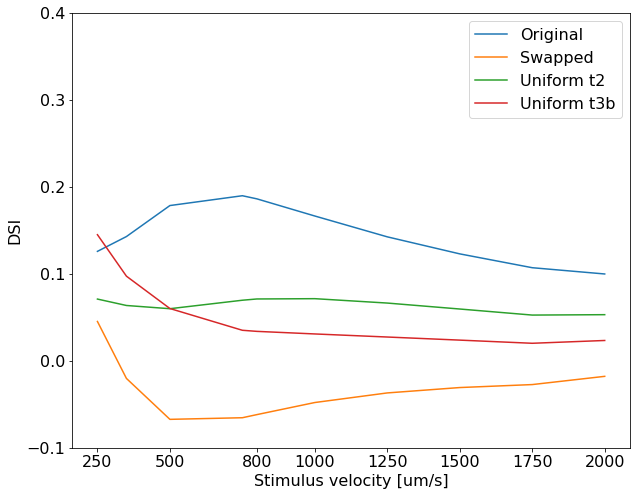

In [18]:
plt.figure(figsize=(10,8))
size = 16
plt.rcParams.update({'font.size': size})
plt.rcParams.update({'axes.titlesize': size})
plt.rcParams.update({'axes.labelsize': size})
plt.rcParams.update({'xtick.labelsize': size})
plt.rcParams.update({'ytick.labelsize': size})

plt.plot(stimulus_velocities, original, '-', label = 'Original')
plt.plot(stimulus_velocities, swapped, '-', label = 'Swapped')
plt.plot(stimulus_velocities, uniformType2, '-', label = 'Uniform t2')
plt.plot(stimulus_velocities, uniformType3b, '-', label = 'Uniform t3b')

plt.xlabel('Stimulus velocity [um/s]')
plt.ylabel('DSI')
plt.xticks([250, 500, 800, 1000, 1250, 1500, 1750, 2000])
plt.legend()
plt.yticks([-0.1,0,0.1,0.2,0.3,0.4])
plt.show()

## Fig. 7c

In [19]:
surround_300Per = np.load('DSI values/OFF_Model_t2_t3b_surround_3_mean_DSI_v.npy')
surround_200Per = np.load('DSI values/OFF_Model_t2_t3b_surround_2_mean_DSI_v.npy')
surround_100Per = np.load('DSI values/OFF_Model_t2_t3b_mean_DSI_v.npy')
surround_50Per = np.load('DSI values/OFF_Model_t2_t3b_surround_0.5_mean_DSI_v.npy')
surround_1Per = np.load('DSI values/OFF_Model_t2_t3b_surround_0.01_mean_DSI_v.npy')

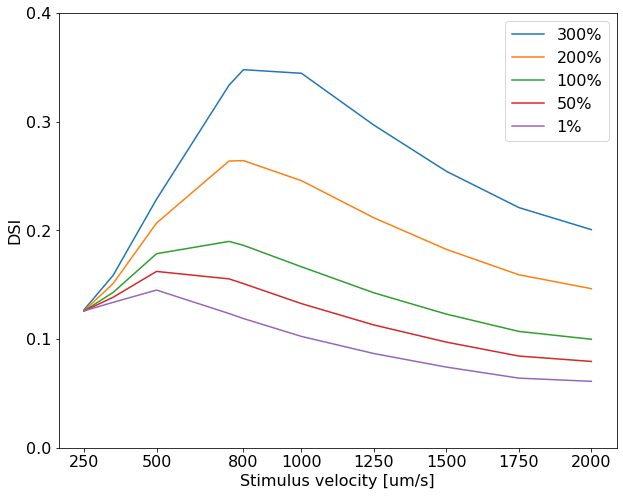

In [20]:
plt.figure(figsize=(10,8))
size = 16
plt.rcParams.update({'font.size': size})
plt.rcParams.update({'axes.titlesize': size})
plt.rcParams.update({'axes.labelsize': size})
plt.rcParams.update({'xtick.labelsize': size})
plt.rcParams.update({'ytick.labelsize': size})

plt.plot(stimulus_velocities, surround_300Per, '-', label = '300%')
plt.plot(stimulus_velocities, surround_200Per, '-', label = '200%')
plt.plot(stimulus_velocities, surround_100Per, '-', label = '100%')
plt.plot(stimulus_velocities, surround_50Per, '-', label = '50%')
plt.plot(stimulus_velocities, surround_1Per, '-', label = '1%')

plt.xlabel('Stimulus velocity [um/s]')
plt.ylabel('DSI')
plt.xticks([250, 500, 800, 1000, 1250, 1500, 1750, 2000])
plt.legend()
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.show()